<a href="https://colab.research.google.com/github/Evgenii1994/DLS/blob/main/hw_7_autoencoders/Homework/hw_7_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

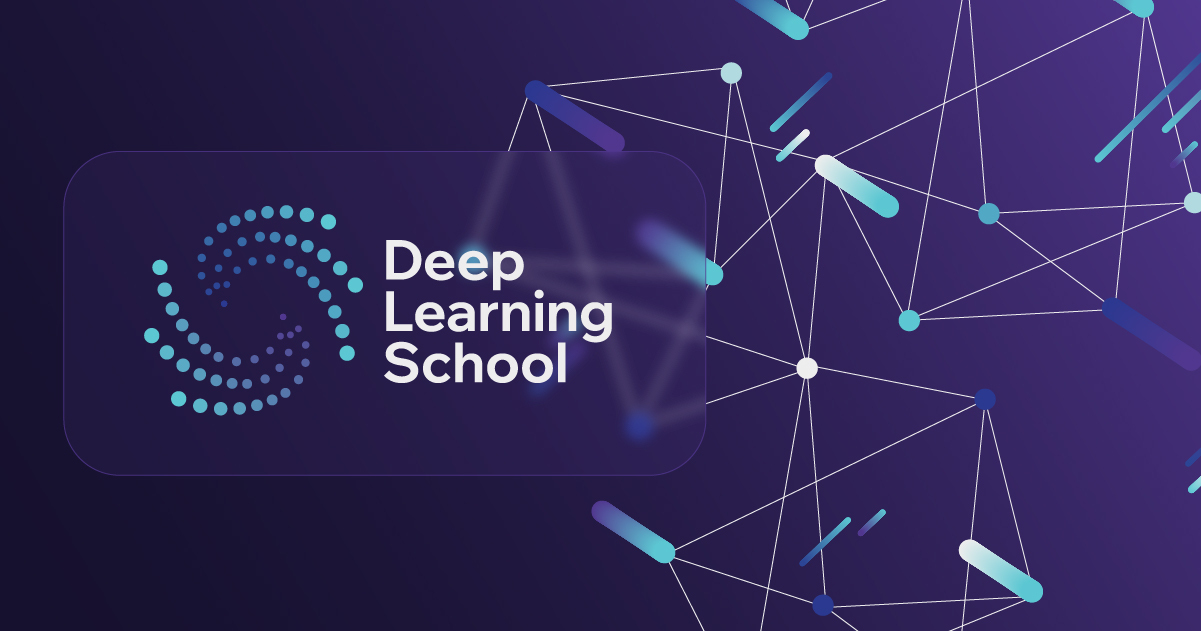


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [ ]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [ ]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [ ]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [ ]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [ ]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

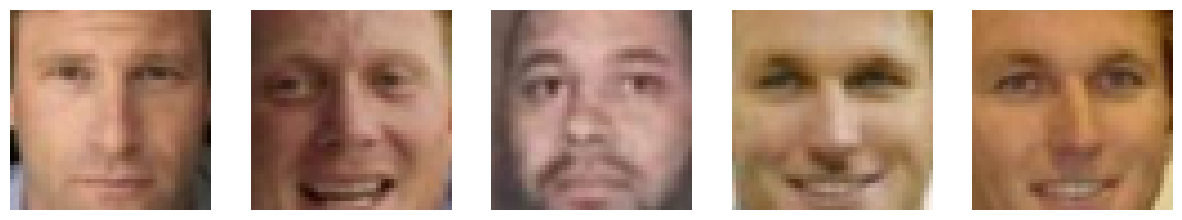

Train set size: 10515
Validation set size: 2628
Image tensor shape: torch.Size([13143, 3, 45, 45])
Attributes tensor shape: torch.Size([13143, 73])


In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd

val_ratio = 0.2
num_total = len(images)
num_val = int(val_ratio * num_total)
num_train = num_total - num_val

transform = transforms.ToTensor()
images_tensor = torch.stack([transform(img) for img in images])  # (N, C, H, W)

attrs_cleaned = attrs.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
attrs_tensor = torch.tensor(attrs_cleaned.values, dtype=torch.float32)

dataset = TensorDataset(images_tensor, attrs_tensor)
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

def show_images(images_tensor, n=5):
    images_np = images_tensor[:n].permute(0, 2, 3, 1).numpy()  # (N, C, H, W) → (N, H, W, C)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        axs[i].imshow(images_np[i])
        axs[i].axis('off')
    plt.show()

show_images(images_tensor)

print("Train set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Image tensor shape:", images_tensor.shape)
print("Attributes tensor shape:", attrs_tensor.shape)

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



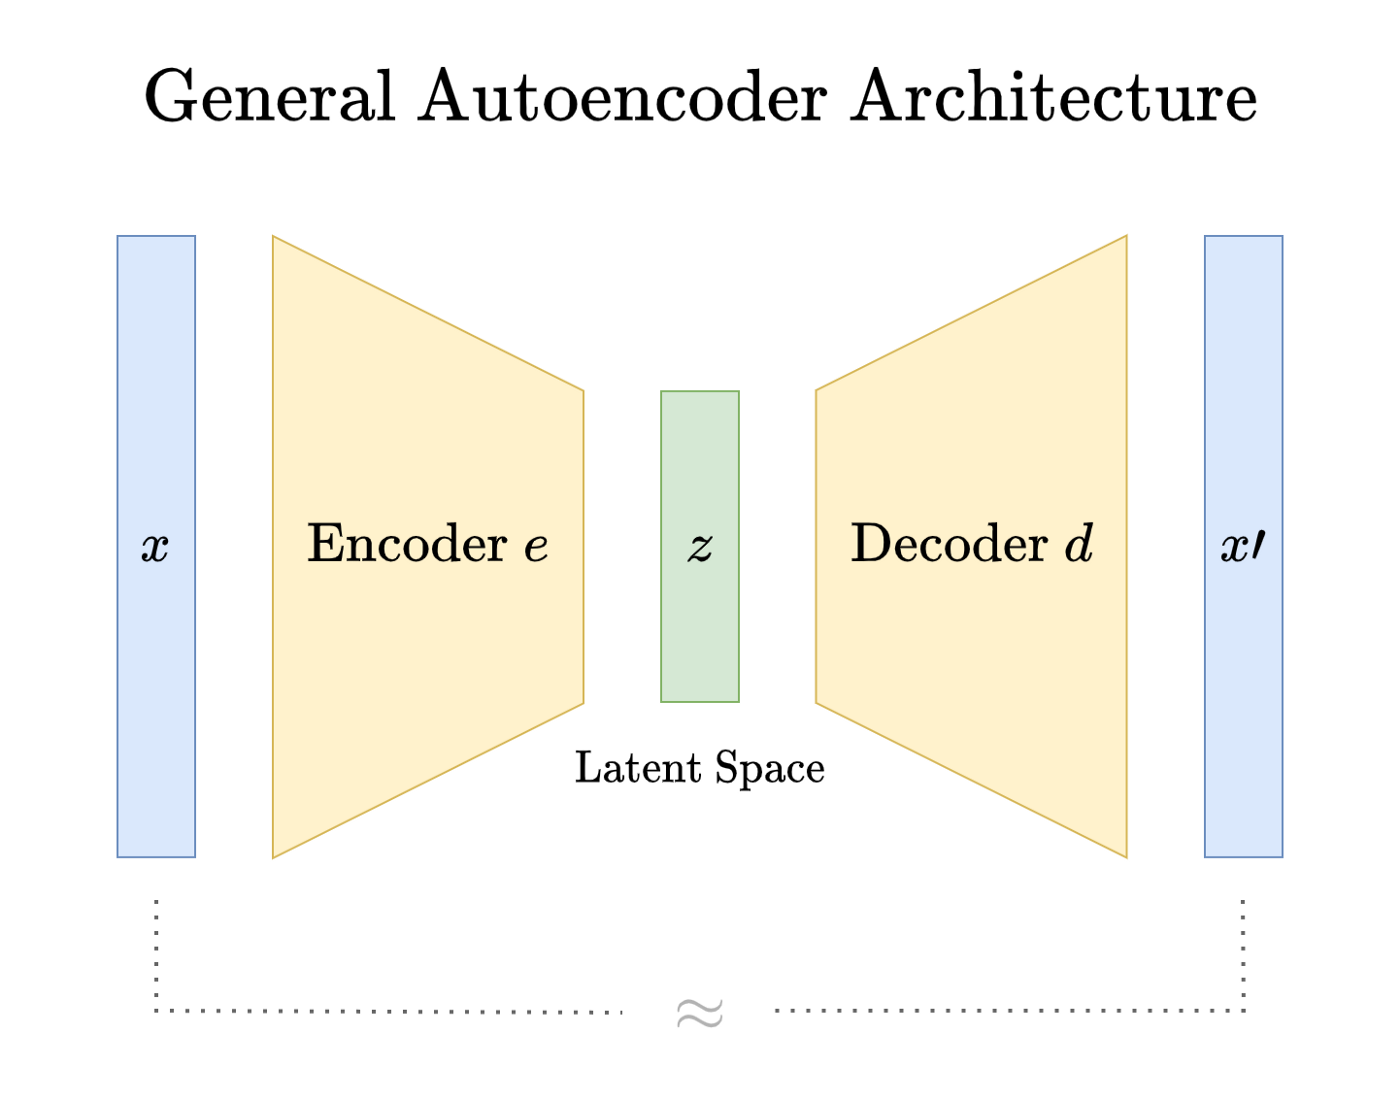

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dim_code = 128

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return F.relu(self.block(x) + x)


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, dim_code)
        )

        self.decoder_fc = nn.Sequential(
            nn.Linear(dim_code, 128 * 6 * 6),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            ResidualBlock(64),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            ResidualBlock(32),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        x = self.decoder_fc(latent_code)
        x = x.view(-1, 128, 6, 6)
        reconstruction = self.decoder_conv(x)
        reconstruction = reconstruction[:, :, :45, :45]
        return reconstruction, latent_code

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()

autoencoder = Autoencoder()

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_autoencoder(model, train_dataset, val_dataset=None,
                      batch_size=64, epochs=20, lr=1e-3, device=None):

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size) if val_dataset else None

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            recon, _ = model(images)
            loss = criterion(recon, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)

        val_loss = 0.0
        if val_loader:
            model.eval()
            with torch.no_grad():
                for images, _ in val_loader:
                    images = images.to(device)
                    recon, _ = model(images)
                    loss = criterion(recon, images)
                    val_loss += loss.item() * images.size(0)
            val_loss /= len(val_loader.dataset)
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}")

In [ ]:
autoencoder = Autoencoder()
train_autoencoder(autoencoder, train_dataset, val_dataset, epochs=50)

Epoch [1/50] - Train Loss: 0.0127 | Val Loss: 0.0091
Epoch [2/50] - Train Loss: 0.0074 | Val Loss: 0.0111
Epoch [3/50] - Train Loss: 0.0055 | Val Loss: 0.0053
Epoch [4/50] - Train Loss: 0.0047 | Val Loss: 0.0056
Epoch [5/50] - Train Loss: 0.0043 | Val Loss: 0.0048
Epoch [6/50] - Train Loss: 0.0039 | Val Loss: 0.0038
Epoch [7/50] - Train Loss: 0.0037 | Val Loss: 0.0045
Epoch [8/50] - Train Loss: 0.0035 | Val Loss: 0.0048
Epoch [9/50] - Train Loss: 0.0034 | Val Loss: 0.0046
Epoch [10/50] - Train Loss: 0.0033 | Val Loss: 0.0033
Epoch [11/50] - Train Loss: 0.0031 | Val Loss: 0.0032
Epoch [12/50] - Train Loss: 0.0030 | Val Loss: 0.0035
Epoch [13/50] - Train Loss: 0.0030 | Val Loss: 0.0030
Epoch [14/50] - Train Loss: 0.0028 | Val Loss: 0.0028
Epoch [15/50] - Train Loss: 0.0028 | Val Loss: 0.0036
Epoch [16/50] - Train Loss: 0.0028 | Val Loss: 0.0027
Epoch [17/50] - Train Loss: 0.0026 | Val Loss: 0.0036
Epoch [18/50] - Train Loss: 0.0026 | Val Loss: 0.0029
Epoch [19/50] - Train Loss: 0.0024 | 

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [ ]:
def show_reconstructions(model, dataloader, num_images=6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images, _ = batch
            images = images.to(device)
            recon, _ = model(images)
            break  # только первая пачка
    fig, axs = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axs[0, i].imshow(images[i].cpu().permute(1, 2, 0))
        axs[0, i].axis("off")
        axs[1, i].imshow(recon[i].cpu().permute(1, 2, 0))
        axs[1, i].axis("off")
    axs[0, 0].set_title("Original")
    axs[1, 0].set_title("Reconstruction")
    plt.show()

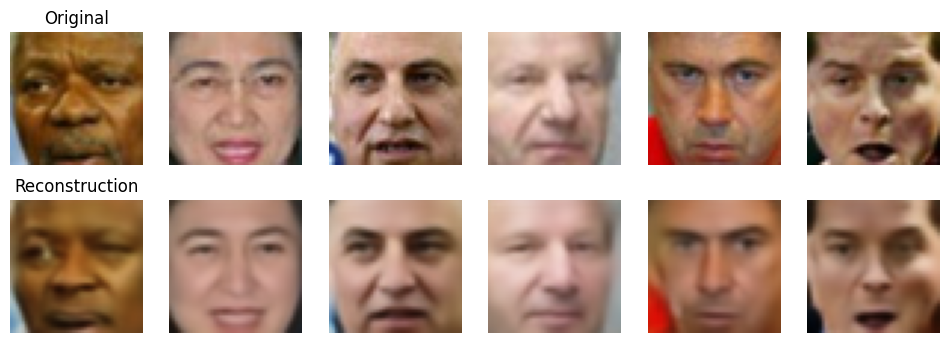

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=64)
show_reconstructions(autoencoder, val_loader)

Что вы можете сказать про результат?

**плюсы**
- Глобальная структура сохранена
- Цвета и тона реалистичны
- Реконструкции осмысленны

**минусы**
- Размытие деталей
- Выражения лица и мимика "сглажены"
- Нет текстур, мелких деталей

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_from_decoder(model, latent_dim=128, n=25, reference_loader=None, device=None):
    """
    Генерация новых изображений на основе латентных векторов и декодера обученного автоэнкодера.

    model: обученный Autoencoder
    latent_dim: размерность латентного пространства
    n: количество генерируемых изображений (желательно квадрат числа, напр. 25)
    reference_loader: если указан, будет использоваться статистика реальных латентных векторов
    device: устройство (cuda или cpu)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model = model.to(device)

    # === Получение параметров распределения реальных латентных векторов ===
    if reference_loader is not None:
        all_latents = []
        with torch.no_grad():
            for images, _ in reference_loader:
                images = images.to(device)
                _, latents = model(images)
                all_latents.append(latents.cpu().numpy())
                if len(all_latents) * images.size(0) >= 1000:
                    break
        all_latents = np.vstack(all_latents)
        mu = all_latents.mean(axis=0)
        std = all_latents.std(axis=0)
        z = np.random.normal(loc=mu, scale=std, size=(n, latent_dim))
    else:
        z = np.random.randn(n, latent_dim)

    z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

    # === Генерация изображений через decoder ===
    with torch.no_grad():
        x = model.decoder_fc(z_tensor)
        x = x.view(-1, 128, 6, 6)  # ← важно: убедитесь, что соответствует архитектуре decoder_conv
        gen_images = model.decoder_conv(x)
        gen_images = gen_images[:, :, :45, :45]  # обрезаем до 45x45, если декодер выдает 48x48

    # === Визуализация ===
    side = int(np.sqrt(n))
    fig, axs = plt.subplots(side, side, figsize=(side * 2, side * 2))
    for i in range(n):
        img = gen_images[i].cpu().permute(1, 2, 0).numpy()
        axs[i // side, i % side].imshow(img)
        axs[i // side, i % side].axis("off")
    plt.suptitle("Generated Faces from Latent Vectors", fontsize=16)
    plt.tight_layout()
    plt.show()

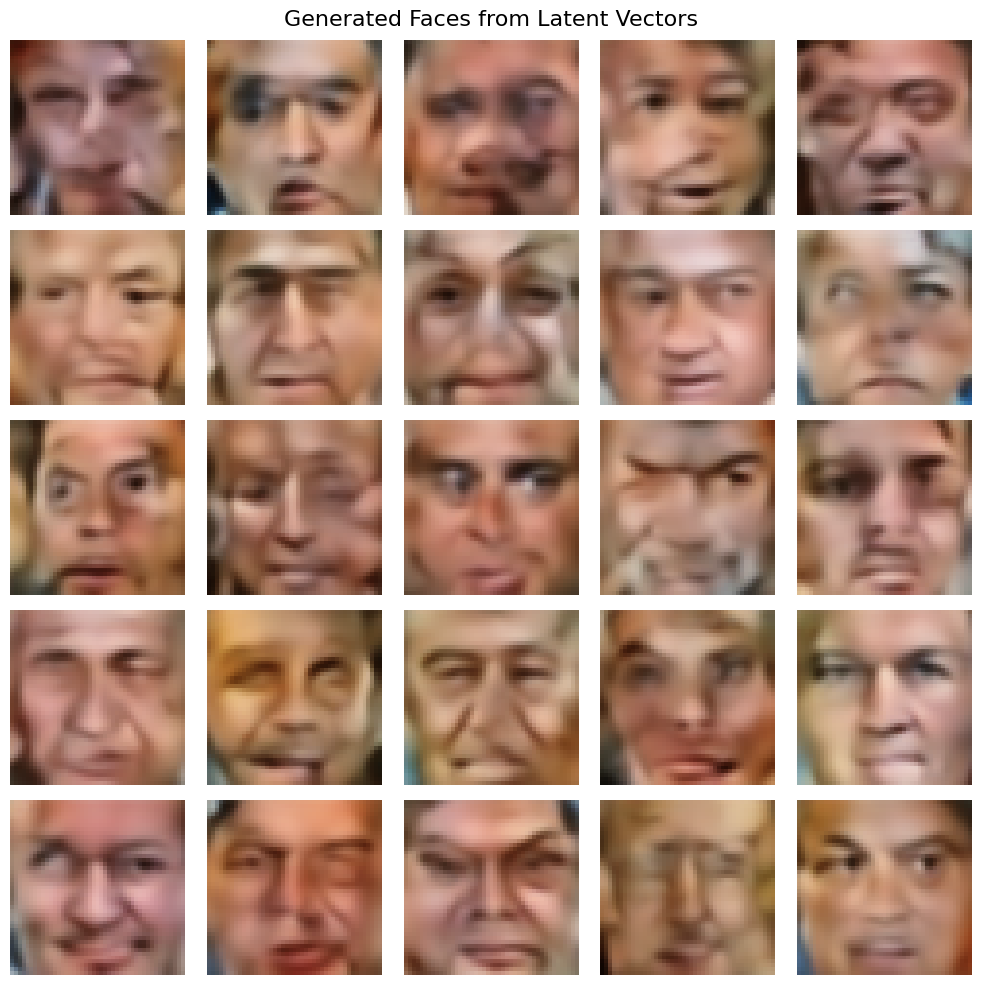

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
generate_from_decoder(autoencoder, latent_dim=dim_code, reference_loader=train_loader)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
def select_smiling_images(attrs_df, num_each=15, smile_col="Smiling", pos_thresh=0.5, neg_thresh=-0.5):
    smiling = attrs_df[attrs_df[smile_col] > pos_thresh]
    not_smiling = attrs_df[attrs_df[smile_col] < neg_thresh]

    if len(smiling) < num_each or len(not_smiling) < num_each:
        raise ValueError(f"Недостаточно данных: smiling={len(smiling)}, not_smiling={len(not_smiling)}")

    smiling_sample = smiling.sample(num_each, random_state=42)
    not_smiling_sample = not_smiling.sample(num_each, random_state=42)

    return smiling_sample.index.tolist(), not_smiling_sample.index.tolist()


def compute_latents(indices, dataset, model, device):
    model.eval()
    latents = []
    with torch.no_grad():
        for idx in indices:
            x, _ = dataset[idx]
            x = x.unsqueeze(0).to(device)
            _, z = model(x)
            latents.append(z.squeeze(0).cpu().numpy())
    return np.array(latents)


def compute_smile_vector(smiling_latents, not_smiling_latents):
    smile_mean = smiling_latents.mean(axis=0)
    no_smile_mean = not_smiling_latents.mean(axis=0)
    return smile_mean - no_smile_mean


def add_smile_to_face(index, dataset, model, smile_vector, device):
    model.eval()
    with torch.no_grad():
        x, _ = dataset[index]
        x = x.unsqueeze(0).to(device)
        _, z = model(x)
        z_smile = z + torch.tensor(smile_vector, dtype=torch.float32, device=device).unsqueeze(0)
        x_recon = model.decoder_fc(z_smile)
        x_recon = x_recon.view(-1, 128, 6, 6)
        recon = model.decoder_conv(x_recon)
        recon = recon[:, :, :45, :45]
        return x.squeeze(0).cpu(), recon.squeeze(0).cpu()

In [ ]:
def show_before_after(original, with_smile):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(original.permute(1, 2, 0))
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(with_smile.permute(1, 2, 0))
    axs[1].set_title("With Smile")
    axs[1].axis("off")
    plt.show()

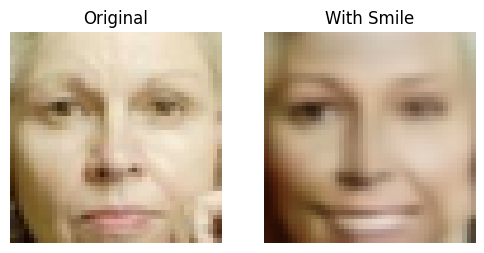

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Индексы по атрибутам
smile_idx, nosmile_idx = select_smiling_images(attrs, num_each=15)

# 2. Латенты
smile_latents = compute_latents(smile_idx, dataset, autoencoder, device)
nosmile_latents = compute_latents(nosmile_idx, dataset, autoencoder, device)

# 3. Вектор улыбки
smile_vector = compute_smile_vector(smile_latents, nosmile_latents)

# 4. Применить улыбку к грустному
sample_index = nosmile_idx[5]
orig_img, smile_img = add_smile_to_face(sample_index, train_dataset, autoencoder, smile_vector, device)

# 5. Визуализация
show_before_after(orig_img, smile_img)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 20

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7, self.latent_dim)
        self.fc_logsigma = nn.Linear(64 * 7 * 7, self.latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(self.latent_dim, 64 * 7 * 7),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder_conv(x)
        h = self.flatten(h)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1, 64, 7, 7)
        return self.decoder_conv(x)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
import torch
import torch.nn.functional as F

def KL_divergence(mu, logsigma):
    kl = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return kl

def log_likelihood(x, reconstruction):
    return F.binary_cross_entropy(reconstruction, x, reduction='sum')

def loss_vae(x, mu, logsigma, reconstruction):
    recon_loss = log_likelihood(x, reconstruction)
    kl_loss = KL_divergence(mu, logsigma)
    return recon_loss + kl_loss

И обучим модель:

In [ ]:
import torch
import torch.optim as optim

criterion = loss_vae

autoencoder = VAE()

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
def train_vae(model, loss_fn, train_loader, test_loader, epochs=10, lr=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            mu, logsigma, reconstruction = model(x)
            loss = loss_fn(x, mu, logsigma, reconstruction)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                mu, logsigma, reconstruction = model(x)
                loss = loss_fn(x, mu, logsigma, reconstruction)
                test_loss += loss.item()

        test_loss /= len(test_loader.dataset)

        print(f"Epoch [{epoch}/{epochs}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

In [ ]:
vae = VAE()
train_vae(vae, loss_fn=loss_vae, train_loader=train_loader, test_loader=test_loader, epochs=50)

Epoch [1/50] | Train Loss: 132.0055 | Test Loss: 101.9411
Epoch [2/50] | Train Loss: 108.2846 | Test Loss: 97.7361
Epoch [3/50] | Train Loss: 105.7008 | Test Loss: 96.6258
Epoch [4/50] | Train Loss: 104.3327 | Test Loss: 93.5571
Epoch [5/50] | Train Loss: 103.4549 | Test Loss: 94.6237
Epoch [6/50] | Train Loss: 102.7500 | Test Loss: 93.2276
Epoch [7/50] | Train Loss: 102.2683 | Test Loss: 93.0498
Epoch [8/50] | Train Loss: 101.8704 | Test Loss: 92.9222
Epoch [9/50] | Train Loss: 101.5546 | Test Loss: 92.7168
Epoch [10/50] | Train Loss: 101.2815 | Test Loss: 91.8065
Epoch [11/50] | Train Loss: 100.9910 | Test Loss: 91.8442
Epoch [12/50] | Train Loss: 100.7788 | Test Loss: 92.4773
Epoch [13/50] | Train Loss: 100.5937 | Test Loss: 91.4994
Epoch [14/50] | Train Loss: 100.4198 | Test Loss: 91.7665
Epoch [15/50] | Train Loss: 100.2564 | Test Loss: 91.7578
Epoch [16/50] | Train Loss: 100.1117 | Test Loss: 91.6305
Epoch [17/50] | Train Loss: 99.9839 | Test Loss: 91.6769
Epoch [18/50] | Train L

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_vae_reconstructions(model, dataloader, device=None, num_images=8):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            _, _, recon = model(x)
            break

    x = x[:num_images].cpu()
    recon = recon[:num_images].cpu()

    fig, axs = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axs[0, i].imshow(x[i].squeeze(), cmap='gray')
        axs[0, i].axis("off")
        axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axs[1, i].axis("off")

    axs[0, 0].set_title("Original")
    axs[1, 0].set_title("Reconstruction")
    plt.suptitle("VAE Reconstructions", fontsize=16)
    plt.tight_layout()
    plt.show()

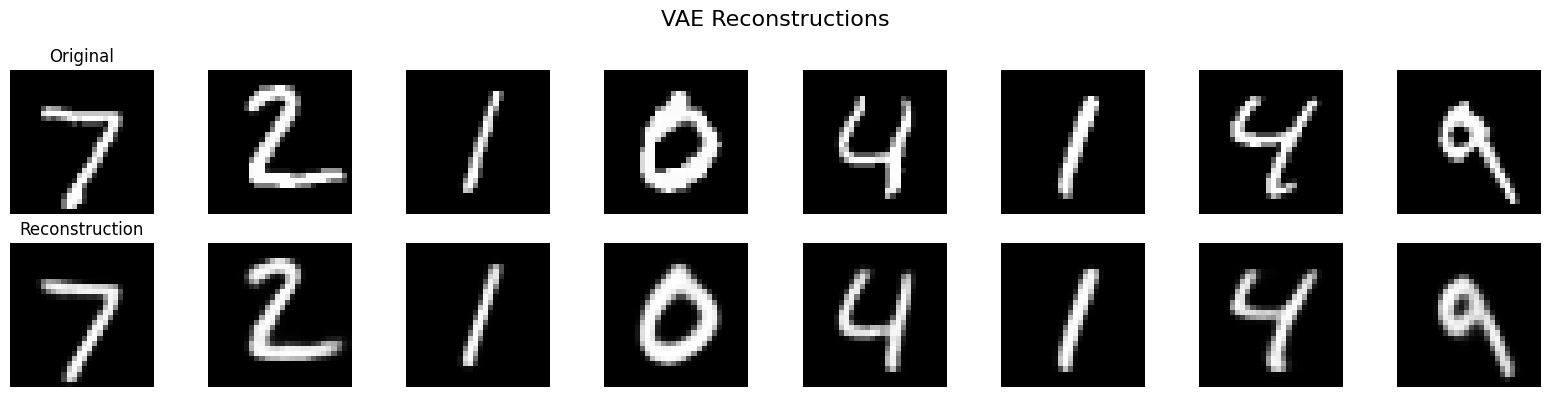

In [ ]:
show_vae_reconstructions(vae, test_loader)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def sample_from_latent_space(model, latent_dim=20, n=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    # Сэмплируем z ~ N(0, I)
    z = np.random.normal(0, 1, (n, latent_dim))
    z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

    with torch.no_grad():
        samples = model.decode(z_tensor).cpu()

    # Визуализация
    fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
    for i in range(n):
        axs[i].imshow(samples[i].squeeze(), cmap='gray')
        axs[i].axis("off")
    plt.suptitle("Generated images from random z ~ N(0, I)", fontsize=14)
    plt.tight_layout()
    plt.show()

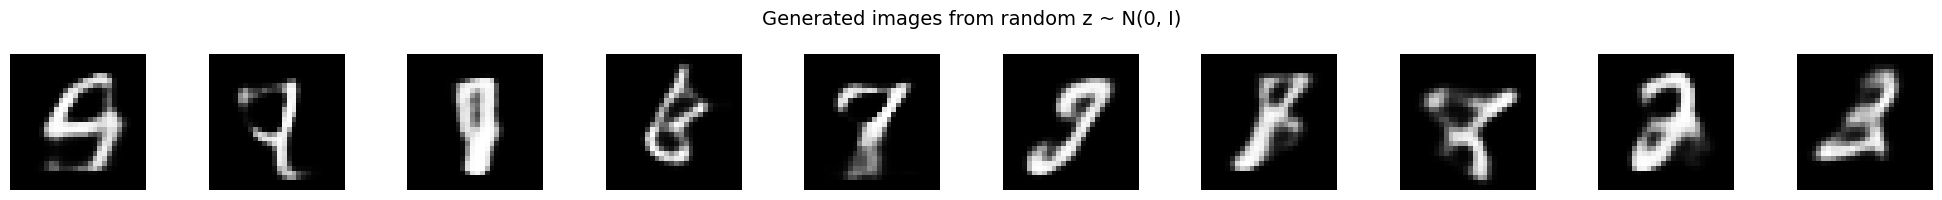

In [ ]:
sample_from_latent_space(vae, latent_dim=20, n=10)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def visualize_latent_space_tsne(model, dataloader, device=None, sample_size=1000, perplexity=30):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    latents = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _, _ = model(x)  # используем mu как латентный вектор
            latents.append(mu.cpu())
            labels.extend(y.cpu().tolist())
            if len(labels) >= sample_size:
                break

    latents = torch.cat(latents, dim=0)[:sample_size].numpy()
    labels = labels[:sample_size]

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label="Digit")
    plt.title("Latent space visualization (t-SNE)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

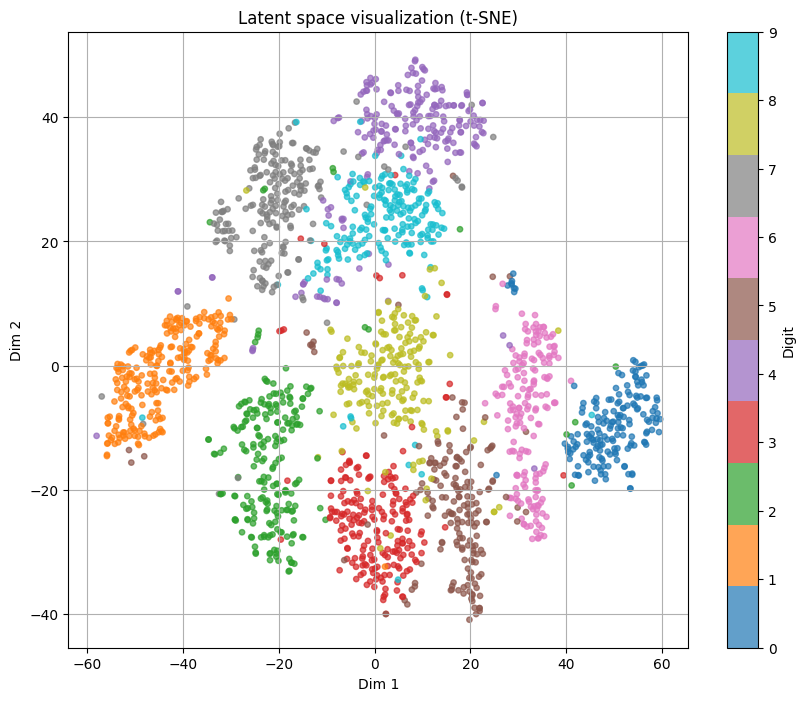

In [ ]:
visualize_latent_space_tsne(vae, test_loader, sample_size=2000)

Что вы думаете о виде латентного представления?

**плюсы**
- Цифры хорошо кластеризуются
- Перекрытия между кластерами минимальны
- Плотности кластеров не оторваны друг от друга

**минусы**
- Перекрытие у 5, 6, 8, 9
- Некоторые точки между кластерами

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.embed_class = nn.Embedding(num_classes, 10)

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(64 * 7 * 7 + 10, latent_dim)
        self.fc_logsigma = nn.Linear(64 * 7 * 7 + 10, latent_dim)

        # --- Decoder ---
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim + 10, 64 * 7 * 7),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, class_num):
        class_emb = self.embed_class(class_num)
        h = self.encoder_conv(x)
        h = self.flatten(h)
        h_concat = torch.cat([h, class_emb], dim=1)
        mu = self.fc_mu(h_concat)
        logsigma = self.fc_logsigma(h_concat)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        class_emb = self.embed_class(class_num)
        z_concat = torch.cat([z, class_emb], dim=1)
        h = self.decoder_fc(z_concat)
        h = h.view(-1, 64, 7, 7)
        reconstruction = self.decoder_conv(h)
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction


In [ ]:
import torch.nn.functional as F

def loss_cvae(x, mu, logsigma, reconstruction):
    recon_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return recon_loss + kl_loss


def train_cvae(model, loss_fn, train_loader, test_loader, epochs=10, lr=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            mu, logsigma, reconstruction = model(x, y)
            loss = loss_fn(x, mu, logsigma, reconstruction)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                mu, logsigma, reconstruction = model(x, y)
                loss = loss_fn(x, mu, logsigma, reconstruction)
                test_loss += loss.item()
        test_loss /= len(test_loader.dataset)

        print(f"Epoch [{epoch}/{epochs}] | Train Loss: {train_loss:.2f} | Test Loss: {test_loss:.2f}")

In [ ]:
cvae = CVAE(latent_dim=20)
train_cvae(cvae, loss_fn=loss_cvae, train_loader=train_loader, test_loader=test_loader, epochs=50)

Epoch [1/50] | Train Loss: 125.96 | Test Loss: 96.65
Epoch [2/50] | Train Loss: 103.63 | Test Loss: 92.37
Epoch [3/50] | Train Loss: 100.67 | Test Loss: 91.13
Epoch [4/50] | Train Loss: 99.15 | Test Loss: 90.21
Epoch [5/50] | Train Loss: 98.13 | Test Loss: 89.36
Epoch [6/50] | Train Loss: 97.44 | Test Loss: 89.00
Epoch [7/50] | Train Loss: 96.86 | Test Loss: 88.43
Epoch [8/50] | Train Loss: 96.45 | Test Loss: 88.04
Epoch [9/50] | Train Loss: 96.09 | Test Loss: 87.65
Epoch [10/50] | Train Loss: 95.77 | Test Loss: 87.30
Epoch [11/50] | Train Loss: 95.47 | Test Loss: 86.65
Epoch [12/50] | Train Loss: 95.23 | Test Loss: 87.89
Epoch [13/50] | Train Loss: 94.97 | Test Loss: 87.14
Epoch [14/50] | Train Loss: 94.77 | Test Loss: 86.89
Epoch [15/50] | Train Loss: 94.59 | Test Loss: 86.72
Epoch [16/50] | Train Loss: 94.42 | Test Loss: 86.62
Epoch [17/50] | Train Loss: 94.28 | Test Loss: 86.68
Epoch [18/50] | Train Loss: 94.11 | Test Loss: 87.62
Epoch [19/50] | Train Loss: 94.03 | Test Loss: 87.05

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_cvae_samples(model, class_id, n=10, latent_dim=20, device=None):
    """
    Генерирует n изображений определённого класса (class_id) через декодер CVAE.

    Parameters:
        model: обученный CVAE
        class_id: int, цифра от 0 до 9
        n: количество изображений
        latent_dim: размерность латентного пространства
        device: устройство
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model = model.to(device)

    # Сэмплируем z ~ N(0, I)
    z = torch.randn(n, latent_dim).to(device)

    # Создаем тензор с метками класса
    class_tensor = torch.full((n,), class_id, dtype=torch.long).to(device)

    # Генерация
    with torch.no_grad():
        samples = model.decode(z, class_tensor).cpu()

    # Визуализация
    fig, axs = plt.subplots(1, n, figsize=(n * 2, 2))
    for i in range(n):
        axs[i].imshow(samples[i].squeeze(), cmap='gray')
        axs[i].axis("off")
    plt.suptitle(f"Generated samples for class {class_id}", fontsize=14)
    plt.tight_layout()
    plt.show()


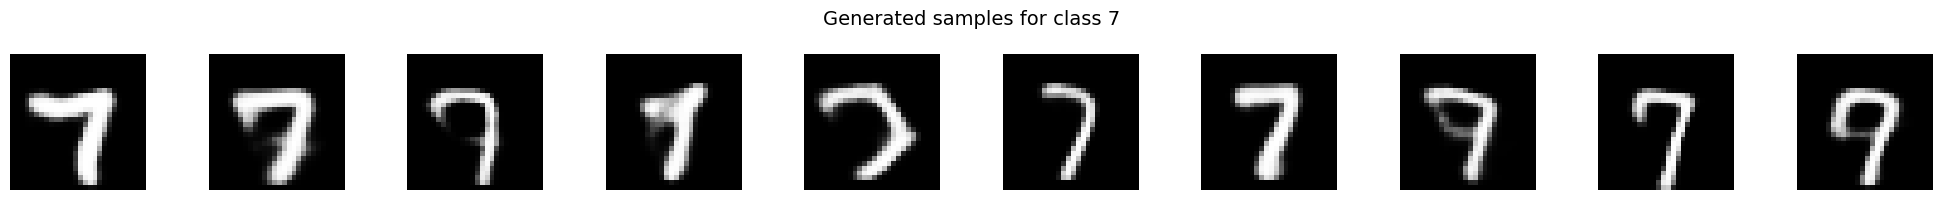

In [ ]:
generate_cvae_samples(cvae, class_id=7, n=10)

In [ ]:
def generate_cvae_conditioned_variants(model, latent_dim=20, device=None):
    """
    Генерирует один и тот же z для всех 10 классов (0–9) и визуализирует результаты.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Один и тот же z
    z = torch.randn(1, latent_dim).repeat(10, 1).to(device)  # [10, latent_dim]

    # Метки от 0 до 9
    class_labels = torch.arange(0, 10, dtype=torch.long).to(device)

    with torch.no_grad():
        generated = model.decode(z, class_labels).cpu()  # [10, 1, 28, 28]

    # Визуализация
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    for i in range(10):
        axs[i].imshow(generated[i].squeeze(), cmap='gray')
        axs[i].set_title(f"Class {i}")
        axs[i].axis("off")
    plt.suptitle("Один z, 10 разных классов (CVAE)", fontsize=14)
    plt.tight_layout()
    plt.show()

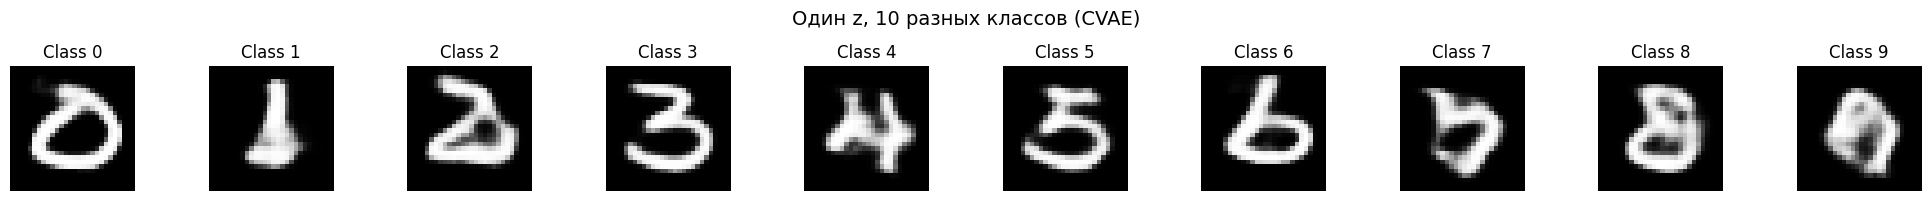

In [ ]:
generate_cvae_conditioned_variants(cvae, latent_dim=20)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

def visualize_cvae_latents_tsne(model, dataloader, sample_size=1000, latent_dim=20, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            mu, logsigma = model.encode(x, y)
            all_mu.append(mu.cpu())
            all_labels.extend(y.cpu().tolist())

            if len(all_labels) >= sample_size:
                break

    all_mu = torch.cat(all_mu, dim=0)[:sample_size].numpy()
    all_labels = all_labels[:sample_size]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    mu_2d = tsne.fit_transform(all_mu)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c=all_labels, cmap="tab10", s=15, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label="Digit")
    plt.title("Latent space of CVAE (t-SNE projection)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()

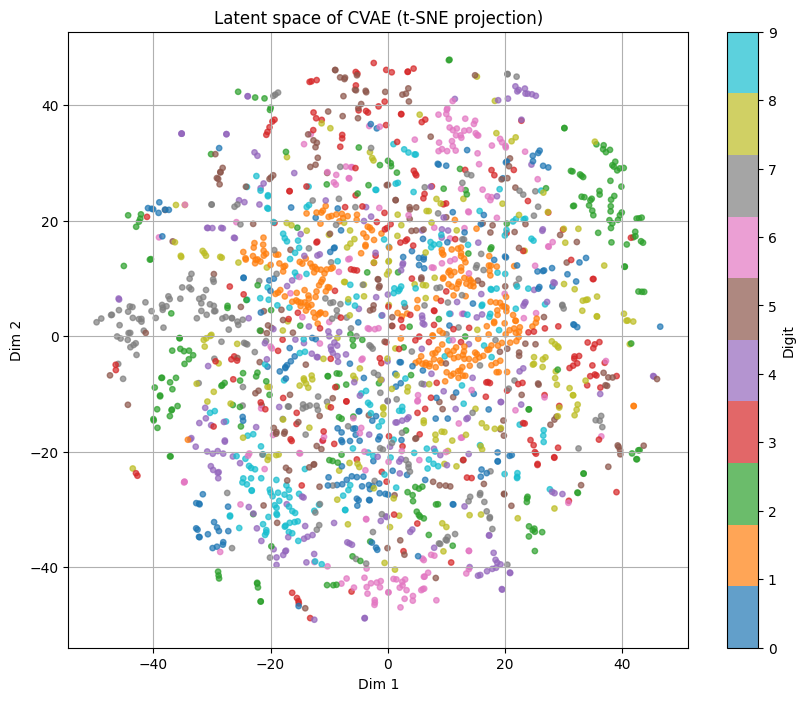

In [ ]:
visualize_cvae_latents_tsne(cvae, test_loader, sample_size=2000)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

- Распределение более равномерное и сферическое
В отличие от VAE, где кластеры цифр были чётко отделены, здесь данные распределены почти равномерно по всему пространству.  

- Сильное перекрытие классов
Цвета сильно смешиваются — это нормально для CVAE, так как информация о классе передаётся отдельно в декодер, а не зашита в z.  

- Цифры "не кластеризуются" по z
Это важная особенность:  

- CVAE не обязан группировать z по классам, потому что он получает y напрямую.
Он учится делать латентное пространство универсальным, а семантику вводить через условие y.

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
import torch.nn as nn

class DenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        recon = recon.view(-1, 1, 28, 28)
        return recon, z

In [ ]:
def add_noise(X, noise_factor=0.5):
    noise = noise_factor * torch.randn_like(X)
    X_noisy = X + noise
    return torch.clamp(X_noisy, 0., 1.)

In [ ]:
from torch.utils.data import Dataset

class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_factor=0.5):
        self.dataset = dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        x_noisy = add_noise(x, self.noise_factor)
        return x_noisy, x

In [ ]:
def train_denoising_autoencoder(model, train_loader, test_loader, epochs=10, lr=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x_noisy, x_clean in train_loader:
            x_noisy, x_clean = x_noisy.to(device), x_clean.to(device)
            recon, _ = model(x_noisy)  # обычный AE
            loss = loss_fn(recon, x_clean)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_loss:.4f}")

In [ ]:
train_noisy = NoisyDataset(train_dataset, noise_factor=0.5)
test_noisy = NoisyDataset(test_dataset, noise_factor=0.5)

train_loader = DataLoader(train_noisy, batch_size=64, shuffle=True)
test_loader = DataLoader(test_noisy, batch_size=64)

In [ ]:
model = DenoisingAE()
train_denoising_autoencoder(model, train_loader, test_loader, epochs=10)

Epoch 1/10 | Train Loss: 0.0007
Epoch 2/10 | Train Loss: 0.0004
Epoch 3/10 | Train Loss: 0.0003
Epoch 4/10 | Train Loss: 0.0003
Epoch 5/10 | Train Loss: 0.0003
Epoch 6/10 | Train Loss: 0.0003
Epoch 7/10 | Train Loss: 0.0003
Epoch 8/10 | Train Loss: 0.0003
Epoch 9/10 | Train Loss: 0.0003
Epoch 10/10 | Train Loss: 0.0002


In [ ]:
import matplotlib.pyplot as plt

def show_denoising_results(model, dataloader, device=None, num_images=8):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    with torch.no_grad():
        for x_noisy, x_clean in dataloader:
            x_noisy = x_noisy.to(device)
            recon, _ = model(x_noisy)
            break

    x_noisy = x_noisy[:num_images].cpu()
    x_clean = x_clean[:num_images]
    recon = recon[:num_images].cpu()

    fig, axs = plt.subplots(3, num_images, figsize=(num_images * 2, 6))

    for i in range(num_images):
        axs[0, i].imshow(x_noisy[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
        axs[2, i].imshow(x_clean[i].squeeze(), cmap='gray')
        axs[2, i].axis('off')

    axs[0, 0].set_ylabel("Noisy", fontsize=12)
    axs[1, 0].set_ylabel("Denoised", fontsize=12)
    axs[2, 0].set_ylabel("Original", fontsize=12)
    plt.suptitle("Denoising Autoencoder: Test Set Results", fontsize=16)
    plt.tight_layout()
    plt.show()

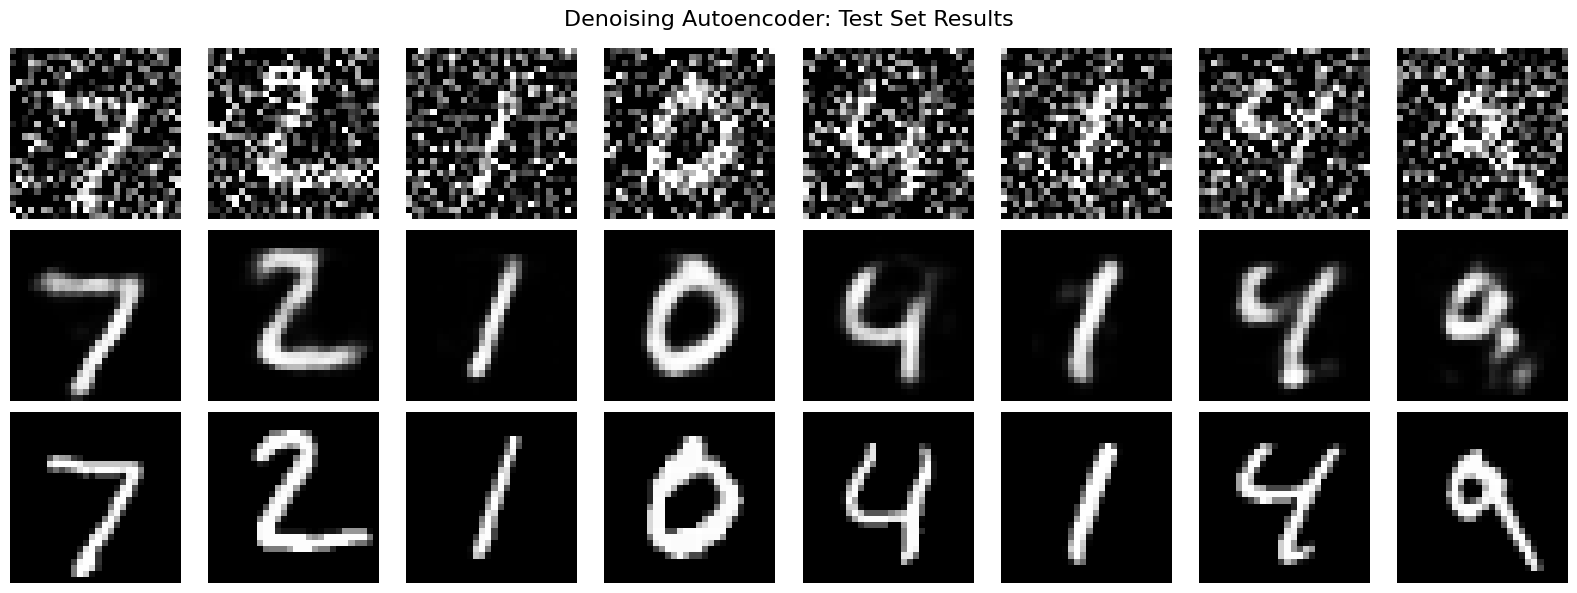

In [ ]:
show_denoising_results(model, test_loader)

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

def extract_latents_and_images(model, dataloader, device):
    model.eval()
    all_latents = []
    all_images = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            mu, _, _ = model(x)
            all_latents.append(mu.cpu())
            all_images.append(x.cpu())

    return torch.cat(all_latents), torch.cat(all_images)


codes, X_train = extract_latents_and_images(vae, train_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
index = NearestNeighbors(n_neighbors=11, algorithm='auto', metric='euclidean')
index.fit(codes.numpy())

NearestNeighbors(metric='euclidean', n_neighbors=11)

In [ ]:
def get_similar(image, model, index, n_neighbors=5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        mu, _, _ = model(image)
        code = mu.cpu().numpy()

    distances, idx = index.kneighbors(code, n_neighbors=n_neighbors)
    return distances[0], X_train[idx[0]]

In [ ]:
def show_similar(image, model, index, n_neighbors=11):
    distances, neighbors = get_similar(image, model, index, n_neighbors)

    plt.figure(figsize=(12, 6))
    plt.subplot(3, 4, 1)
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title("Original")

    for i in range(n_neighbors):
        plt.subplot(3, 4, i + 2)
        plt.imshow(neighbors[i].squeeze(), cmap='gray')
        plt.title(f"Dist={distances[i]:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

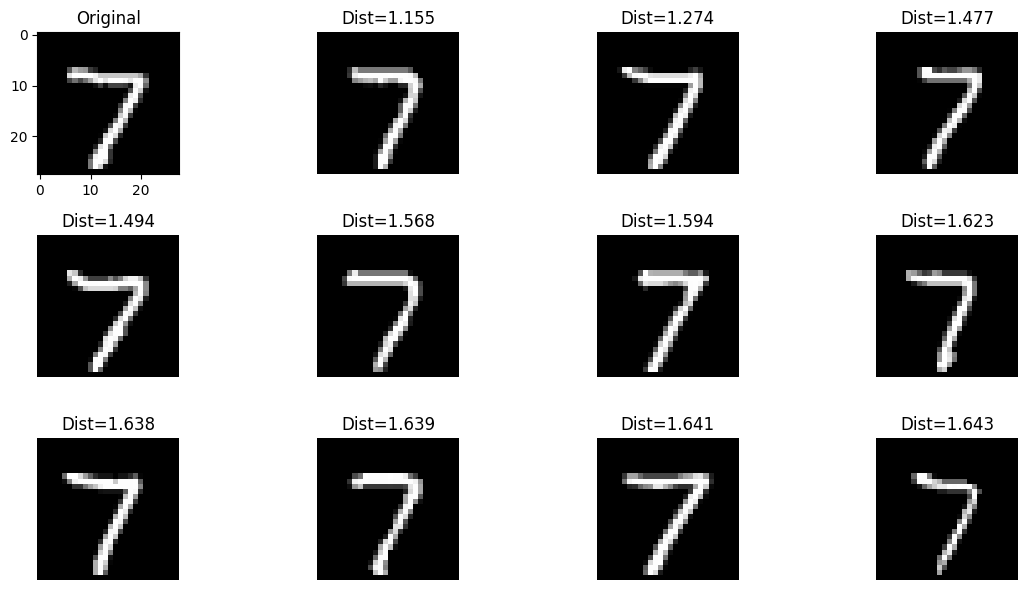

In [ ]:
example_batch = next(iter(test_loader))
example_image = example_batch[0][0]

show_similar(example_image, model=vae, index=index, n_neighbors=11)